# Projekt
Zbiór danych: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [1]:
import os
import urllib.request
from zipfile import ZipFile
from scipy.io.arff import loadarff 

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (16,6)
# sns.set_context('paper', font_scale=1.4)
# plt.rcParams['font.size'] = 16
sns.set(font_scale = 1.3)
sns.set_style("ticks",{'axes.grid' : True})
sns.set_palette("deep")

In [2]:
# helper function
def annotate(g):
    if isinstance(g, sns.axisgrid.FacetGrid):
        g = g.axes[0][0]
    for p in g.patches:
        g.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'top', xytext = (0, 12), textcoords = 'offset points')

## Pobranie danych
Dane są podzielone względem pięciu okresów (lat) przewidywania (*forecasting period*).

UCI ML Repository udostępnia żądane dane w formie pięciu plików `.arff`, po jednym pliku dla każdego okresu przewidywania. Te dane są łączone i zapisywane jako jeden plik `data/dataset.csv`.

W celu pobrania i zapisania danych należy wykonać poniższą komórkę (może to chwilę potrwać). 

In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')
    urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip', filename=os.path.join('data', 'data.zip'))
    
    with ZipFile(os.path.join('data', 'data.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
    
    years_df = []
    for i in range(1,6):
        raw_data = loadarff(os.path.join('data', f'{i}year.arff'))
        df = pd.DataFrame(raw_data[0])
        df['class'] = pd.to_numeric(df['class'])
        df['bankruptcy_after'] = df['class'] * (6 - i)
        df['year'] = i
        years_df.append(df)
        
    df = pd.concat(years_df, ignore_index=True)
    df.to_csv(os.path.join('data', 'dataset.csv'), index=False)

## Wczytanie danych

In [4]:
df = pd.read_csv(os.path.join('data', 'dataset.csv'))
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,bankruptcy_after,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,0,1
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,0,1
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,0,1
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,0,1
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,0,1


### Rozmiar danych i typy zmiennych

In [5]:
df.shape

(43405, 67)

In [6]:
df.dtypes.value_counts()

float64    64
int64       3
dtype: int64

### Opis poszczególnych zmiennych

Bazowe 64 atrybuty to liczby zmiennoprzecinkowe. Ich dokładny opis znajduje się w osobnym [pliku pdf](descripction.pdf).

Ponado zbiór zawiera trzy zmienne kategoryczne. Należą do nich:
* binarna zmienna docelowa `class` oznaczająca, czy firma zbankrutowała
* zmienna `bankruptcy_after` oznaczająca ile lat po okresie przewidywania firma zbankrutowała
* zmienna `year` oznaczająca z którego roku przewidywania pochodzą dane

Kategorie `bankruptcy_after` i `year`:
* 0 - firma nie zbankrutowała; dane z 1...5 roku przewidywania
* 1 - firma zbankrutowała po 1 roku; dane z 5 roku przewidywania
* 2 - firma zbankrutowała po 2 latach; dane z 4 roku przewidywania
* 3 - firma zbankrutowała po 3 latach; dane z 3 roku przewidywania
* 4 - firma zbankrutowała po 4 latach; dane z 2 roku przewidywania
* 5 - firma zbankrutowała po 5 latach; dane z 1 roku przewidywania

### Braki danych
Każda kolumna zawiera jakieś braki.

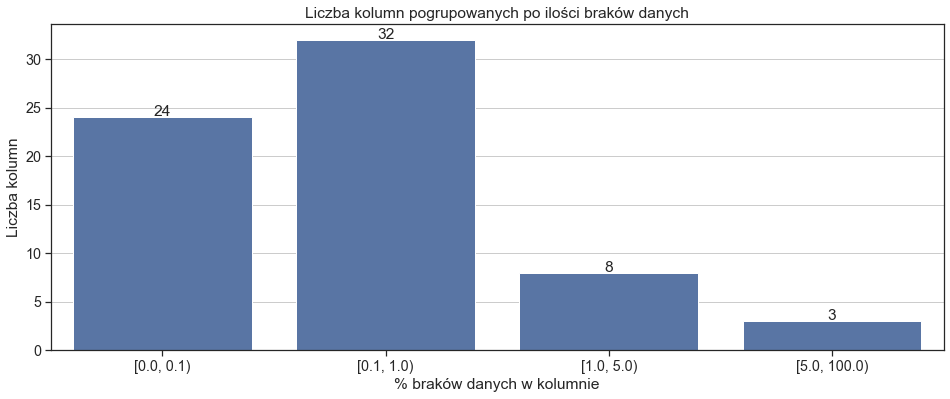

In [7]:
missing = (df.isna().sum() / df.shape[0] * 100).to_frame(name='percent')
missing['bin'] = pd.cut(missing['percent'], bins=[0, 0.1, 1, 5, 100], right=False)
g = sns.countplot(data=missing, x='bin', color='#4c72b0')
annotate(g)
plt.title("Liczba kolumn pogrupowanych po ilości braków danych")
plt.xlabel("% braków danych w kolumnie")
plt.ylabel("Liczba kolumn")
plt.show()

In [8]:
missing[missing['percent'] > 5].sort_values(by='percent')

,percent,bin
Attr27,6.367930,"[5.0, 100.0)"
Attr21,13.486925,"[5.0, 100.0)"
Attr37,43.736897,"[5.0, 100.0)"


Wszystkie kolumny (poza docelową) zawierają braki danych. Jednak są to braki na poziomie mniejszym niż 0.1% (24 kolumny) oraz mniejszym niż 1% (32 kolumny). Należy rozważyć jakiś sposób wypełnienia tych braków, np. przez średnią lub medianę.

Trzy kolumny: `Attr27`, `Atrr21`, `Atrr37` stosunkowo często zawierają braki danych. Możemy rozważyć usunięcie tych kolumn.

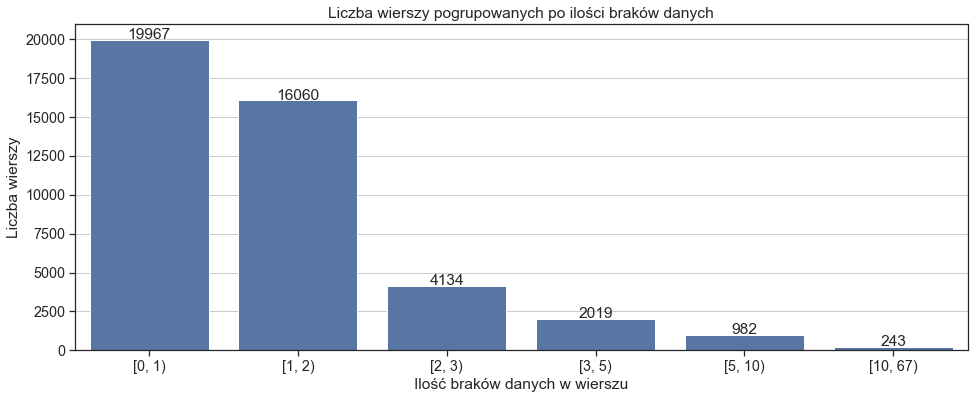

In [9]:
missing_rows = df.isna().sum(axis=1).to_frame(name='number')
missing_rows['bin'] = pd.cut(missing_rows['number'], bins=[0, 1, 2, 3, 5, 10, 67], right=False)
g = sns.countplot(data=missing_rows, x='bin', color='#4c72b0')
annotate(g)
plt.title("Liczba wierszy pogrupowanych po ilości braków danych")
plt.xlabel("Ilość braków danych w wierszu")
plt.ylabel("Liczba wierszy")
plt.show()

243 wiersze posiadają ponad 10 zmiennych z brakami danych. Możemy rozważyć usunięcie tych wierszy.

## Analiza zmiennych

### Rozkład klas docelowych

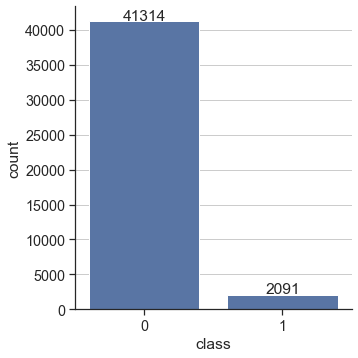

In [10]:
g = sns.catplot(data=df, x='class', kind='count', color='#4c72b0')
annotate(g)

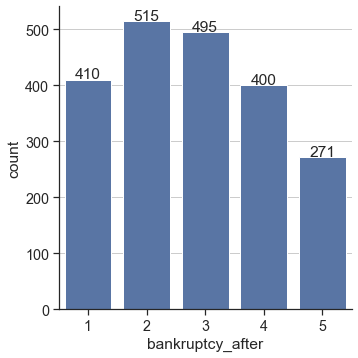

In [11]:
g = sns.catplot(data=df[df['class'] == 1], x='bankruptcy_after', kind='count', color='#4c72b0')
annotate(g)

**Obserwacja**

Zaledwie 5% wszystkich wszystkich rozważanych przypadków skończyło się bankructwem firmy, zatem nasz główny podział na klasy jest bardzo niezbalansowany.

Podobna liczba firm znajduje się w każdej kategorii przy podziale na liczbę lat, po których nastąpiło bankructwo.

### Korelacje

In [12]:
df_corr = df.corr()
df_corr.drop(['bankruptcy_after', 'class'])[['bankruptcy_after', 'class']].describe()

,bankruptcy_after,class
count,65.000000,65.000000
mean,-0.004834,-0.005149
std,0.013591,0.014776
min,-0.056659,-0.055717
25%,-0.009052,-0.015212
50%,-0.001681,-0.001802
75%,-0.000644,-0.000368
max,0.039472,0.043488


**Obserwacja**

Jak możemy zauważyć, nasze możliwe klasy docelowe `class` i `bankruptcy_after` nie są wyraźnie skorelowane z żadną inną zmienną. Nie znaczy to jednak, że nie sią w jakiś sposób od nich zależne.

Spróbujmy znaleźć najmocniejsze korelacje między pozostałymi zmiennymi. Wybieramy wszystkie te, które mają korelację z inną zmienną na poziomie co najmniej 0.9

<AxesSubplot:>

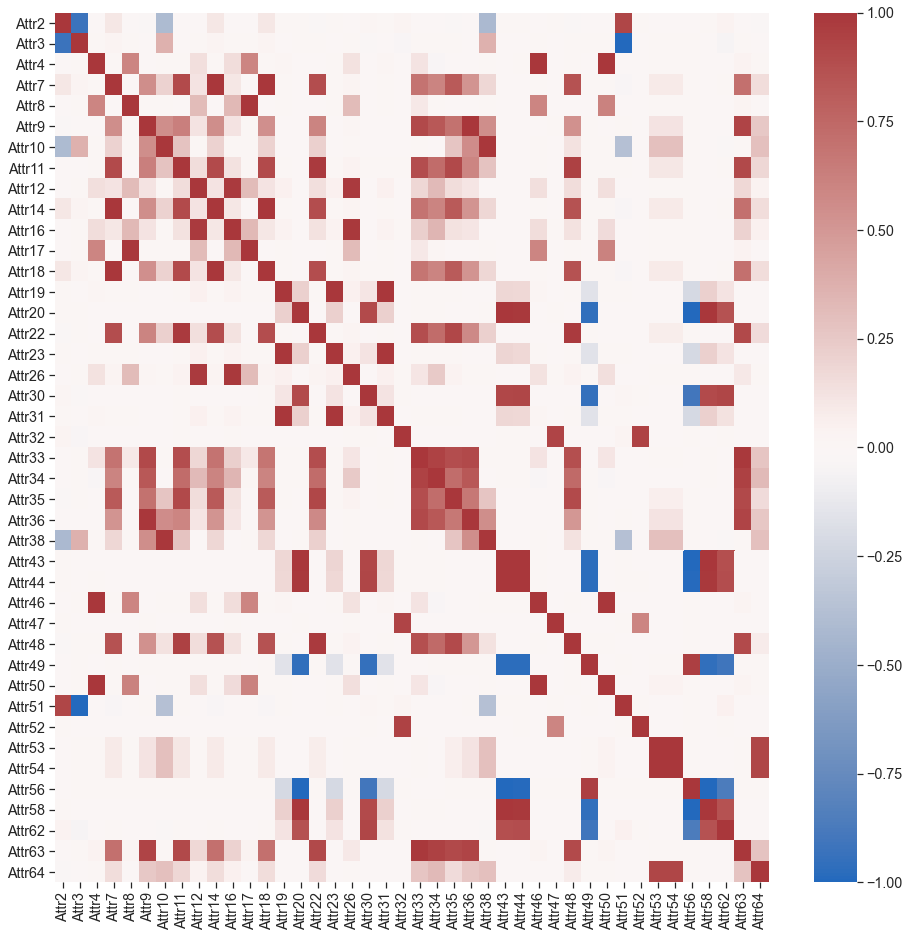

In [13]:
tmp = df_corr.iloc[:-3, :-3].unstack();
vars = tmp[(np.abs(tmp) > 0.9) & (tmp != 1.0)].index.get_level_values(0).unique()

plt.figure(figsize = (16,16))
sns.heatmap(df_corr.filter(vars, axis=0).filter(vars, axis=1), annot=False, cmap="vlag", vmin=-1, vmax=1, center=0, fmt=".2f")

In [14]:
df_corr_temp = df_corr.iloc[:-3, :-3].copy()
np.fill_diagonal(df_corr_temp.values, np.nan)
(df_corr_temp.abs().max() > 0.90).value_counts()

True     42
False    22
dtype: int64

**Obserwacja**

Bardzo dużo zmiennych (aż 42) ma bardzo silną korelację z co najmniej jedną inną zmienną. 

Można by zadać pytanie, czy te powiązania można wywnioskować na podstawie opisu zmiennych. Tak więc na przykładzie `X2`, `X3`:
- X1 net profit / total assets
- X2 total liabilities / total assets
widzimy wspólny mianownik, ale zysk netto może być odwrotnie proporcjonalny do zobowiązań finansowych, co daje silną ujemną korelację.

Widzimy także bardzo silną grupę `X33`, `X34`, `X35`, `X36`. Zmienne te dotyczą:
- X33 operating expenses / short-term liabilities
- X34 operating expenses / total liabilities
- X35 profit on sales / total assets
- X36 total sales / total assets
czyli w sumie są to dosyć podobne ułamki.

Widzimy, że zmienne mają charakter różnych operacji arytmetycznych na tych samych składnikach, więc to logiczne, że istnieją silne korelacje. Można rozważyć pozbycie się kilku kolumn o podobnej wymowie.

Ponieważ jesteśmy pozbawieni bez opinii eksperta, ważniejsze są bardziej nieuzasadnione powiązania, jak na przykład pomiędzy:
- X43 rotation receivables + inventory turnover in days
- X44 (receivables * 365) / sales

a
- X56 (sales - cost of products sold) / sales
- X58 total costs /total sales

Wszystkie grupy silnych korelacji generuje poniższa komórka:

In [15]:
df_corr_temp = df_corr.where(np.tri(*df_corr.shape, k=-1, dtype=bool))
df_corr_temp = df_corr_temp.iloc[:-3, :-3]

already_in = set()
result = []
for col in df_corr_temp:
    perfect_corr = df_corr_temp[col][df_corr_temp[col].abs() > 0.90].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result.append(perfect_corr)
result

[['Attr3', 'Attr51', 'Attr2'],
 ['Attr46', 'Attr50', 'Attr4'],
 ['Attr11', 'Attr14', 'Attr18', 'Attr7'],
 ['Attr17', 'Attr8'],
 ['Attr33', 'Attr36', 'Attr63', 'Attr9'],
 ['Attr38', 'Attr10'],
 ['Attr16', 'Attr26', 'Attr12'],
 ['Attr23', 'Attr31', 'Attr19'],
 ['Attr30', 'Attr43', 'Attr44', 'Attr49', 'Attr56', 'Attr58', 'Attr20'],
 ['Attr35', 'Attr48', 'Attr63', 'Attr22'],
 ['Attr47', 'Attr52', 'Attr32'],
 ['Attr63', 'Attr34'],
 ['Attr54', 'Attr64', 'Attr53']]

### Wartości odstające

W rozważanym zbiorze danych możemy dostrzec olbrzymi problem z wartościami odstającymi.

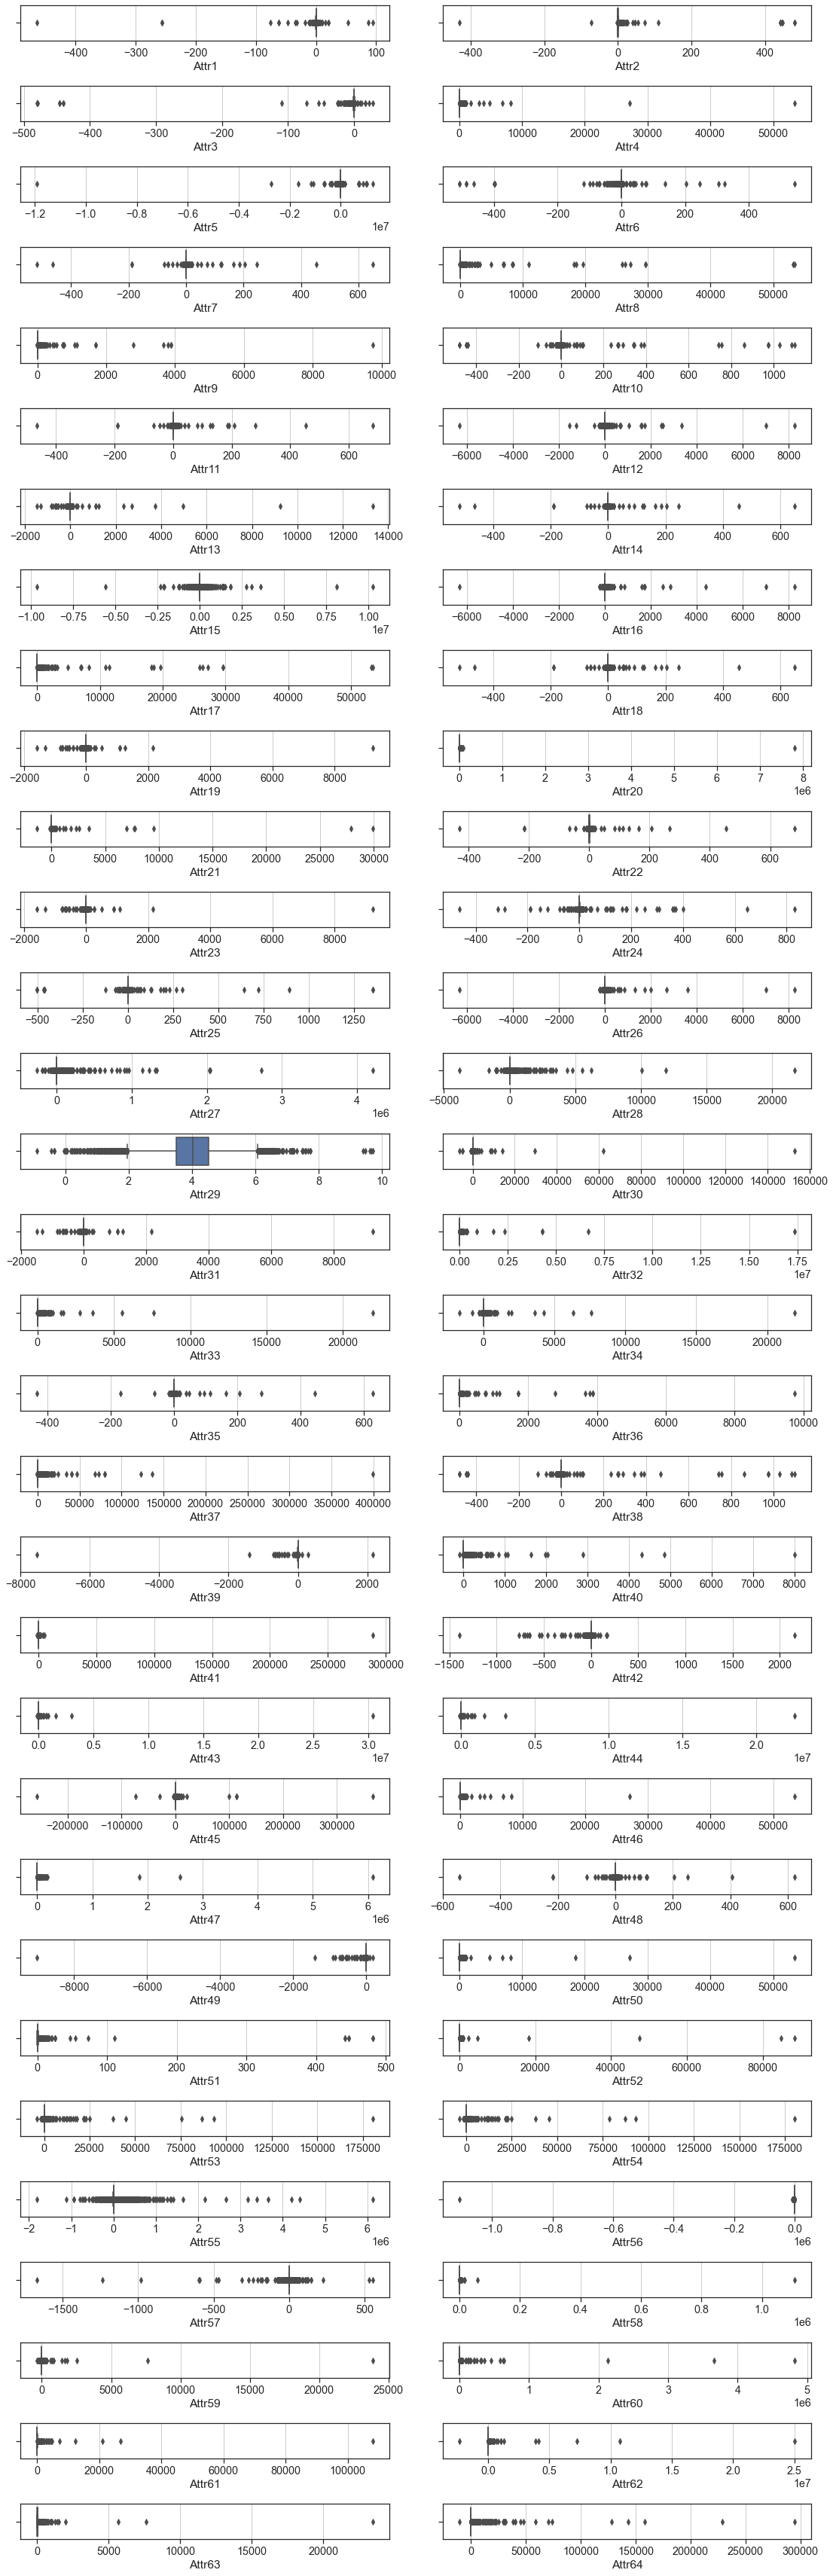

In [16]:
fig, axs = plt.subplots(32, 2 , figsize=(16, 48))
fig.tight_layout(pad=2.0)

for i, col in enumerate(df.columns[:-3]):
    sns.boxplot(data=df, x=col, ax=axs[i//2, i%2])


**Obserwacja**

Dosłownie w każdym przypadku - poza jednym `X29 - logarithm of total assets` - zdecydowana większość obserwacji (>50%) skupione jest w okolicach 0. Ponadto jak już wspomnieliśmy, istnieje bardzo dużo wartości odstających.

Ponadto możemy zaobserwować bardzo różne rzędy wielkości.

### Czy możemy pozbyć się obserwacji odstających?
Ze względu na charakterystykę danych, wprowadzamy nową zmienną - liczbę wartości odstających w każdym wierszu.
Za wartości odstające w danej kolumnie uznajemy wszystkie takie $x$, że:
$$ x < Q_1 - 1.5 IQR \lor x > Q_3 + 1.5 IQR $$ 

In [17]:
tmp = df.drop(columns=['class', 'bankruptcy_after', 'year']) # bez zmiennych kategorycznych
Q1 = tmp.quantile(0.25)
Q3 = tmp.quantile(0.75)
IQR = Q3 - Q1
df['outliers'] = ((tmp < (Q1 - 1.5*IQR)) | (tmp > (Q3 + 1.5*IQR))).sum(axis=1)

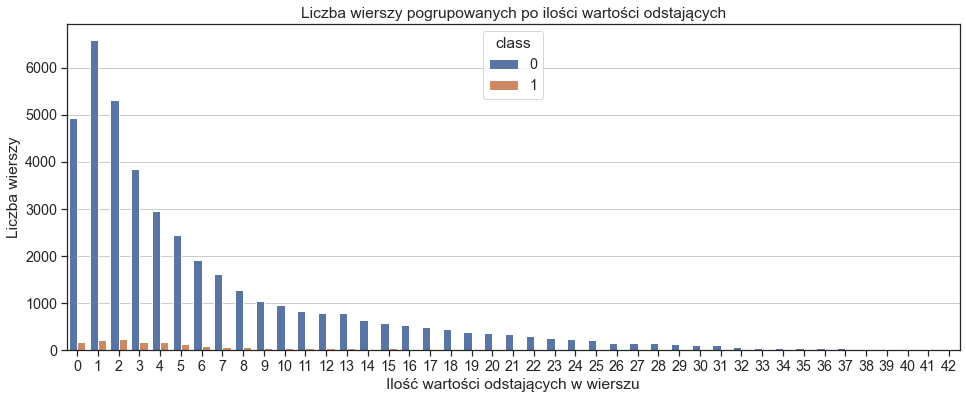

In [18]:
sns.countplot(data=df, x='outliers', hue='class')
plt.title("Liczba wierszy pogrupowanych po ilości wartości odstających")
plt.xlabel("Ilość wartości odstających w wierszu")
plt.ylabel("Liczba wierszy")
plt.show()

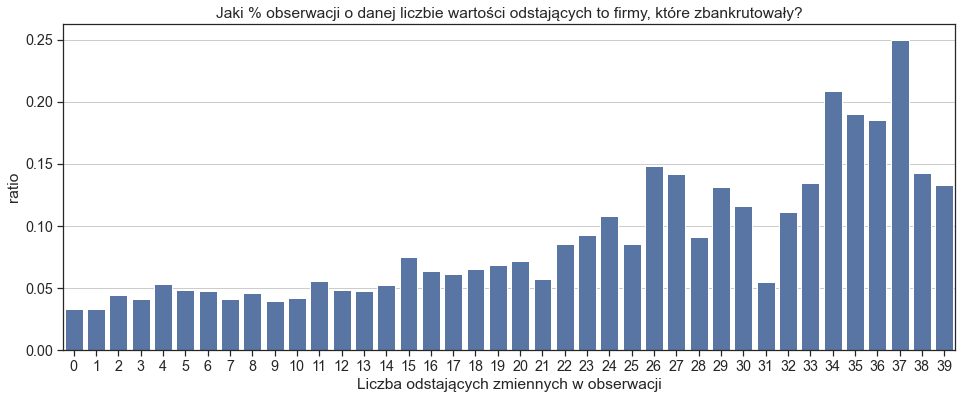

In [19]:
tmp = df.groupby(['outliers', 'class']).count().iloc[:, 0].to_frame(name='n')
tmp = tmp.reset_index().pivot(index='outliers', columns='class', values='n')
tmp = tmp.rename_axis(None, axis=1).rename_axis(None, axis=0)
tmp.columns = tmp.columns.astype(str)
tmp['ratio'] = tmp['1'] / (tmp['0'] + tmp['1'])
tmp = tmp.dropna()
g = sns.barplot(x=tmp.index, y=tmp['ratio'], color='#4c72b0')
g.set_title("Jaki % obserwacji o danej liczbie wartości odstających to firmy, które zbankrutowały?")
g.set_xlabel("Liczba odstających zmiennych w obserwacji")
plt.show()

**Obserwacja**

Przypominamy, że firmy, które zbankrutowały, stanowią ok. 5% wszystkich danych.

Każda wiersz zawiera pewną liczbę wartości odstających (w danej kolumnie). Ta liczba wartości odstających waha się od 0 do 40.

Nie ważne ile jest tych wartości odstających w wierszu, procent firm które zbankrutowały pozostaje w miarę podobny.

Znaczący wzrost firm-banktrutów dostrzegamy dopiero, gdy liczba wartości odstających jest duża. Jednak na przykład wiersze, dla których `outliers > 20` stanowią małą część wszystkich danych.

**Wniosek.** Nie możemy pozbyć się wierszy z wartościami odstającymi. 

### Rozkład klas ze względu na wybrane zmienne
Spróbujemy zbadać zachowanie się klas względem poszczególnych zmiennych.
Znowu, ze względu na wartości odstające które strasznie zaburzają wygląd wszelkich wykresów, użyjemy zmiennych `X29`, `X55` jako tych najładniejszych.

<AxesSubplot:xlabel='bankruptcy_after', ylabel='Attr29'>

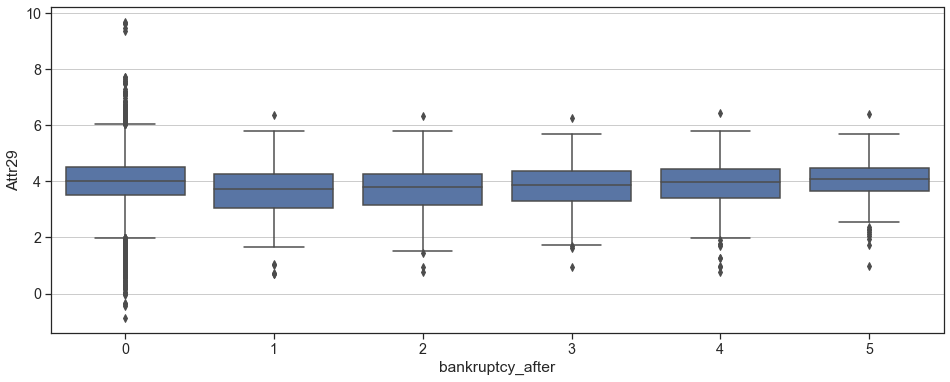

In [20]:
sns.boxplot(data=df, x='bankruptcy_after', y='Attr29', color='#4c72b0')

<AxesSubplot:xlabel='Attr55', ylabel='Attr29'>

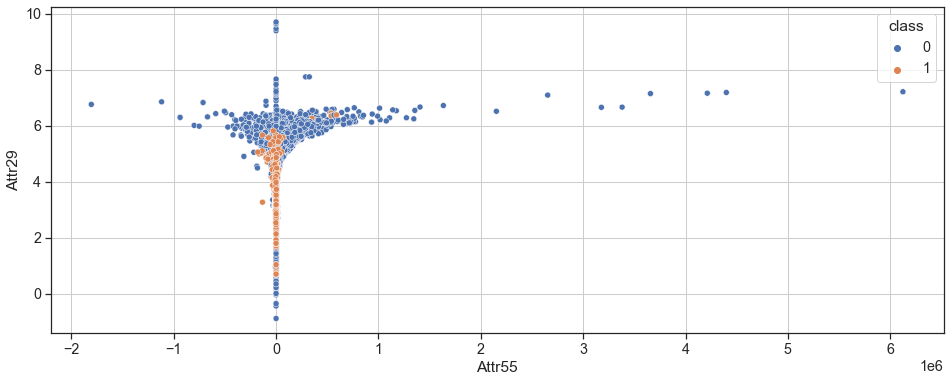

In [21]:
sns.scatterplot(data=df, x='Attr55', y='Attr29', hue='class')

### Wpływ innych zmiennch na bankructwo firmy

Sprawdźmy jak na wykresie będzie przedstawiać się zależność zmniennej 'class' od zmiennych:

`X3` -  working capital / total assets

`X19` - gross profit/sales 

`X53` - equity / fixed assets,  po zmianie wartości odstających. 

Zgodnie z naszym wcześniejszym wnioskowaniem, wykresy te moga być przekłamane, stwórzmy je jednak w ramach dodatkowej informacji. Dla porównania dodamy wykresy zmiennych przed modyfikacją danych.
Wartości odstające zastąpimy medianą zmiennej.

<AxesSubplot:xlabel='Attr3', ylabel='Density'>

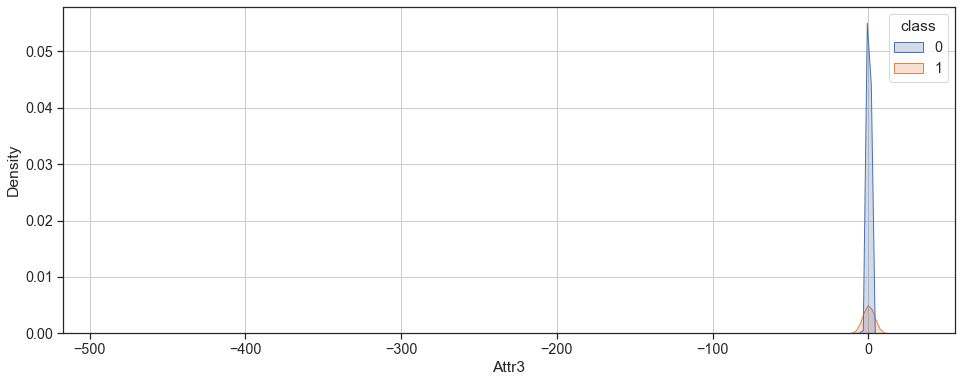

In [22]:
sns.kdeplot(data=df, x="Attr3", hue="class", fill=True)

In [23]:
print(df['Attr3'].quantile(0.02)) 
print(df['Attr3'].quantile(0.98)) 
print(df['Attr3'].quantile(0.5))

-0.6308256
0.8196272000000002
0.19661


Usuwamy zatem wartości odstające, poniżej 2. i powyżej 98. kwantyla.

In [24]:
df['Attr3'] = np.where((df['Attr3'] > 0.819)|(df['Attr3'] < -0.63) ,0.196, df['Attr3'])

In [25]:
df['Attr3']

0        0.396410
1        0.472250
2        0.267130
3        0.458790
4        0.229600
           ...   
43400    0.038857
43401    0.196000
43402   -0.275990
43403    0.015449
43404   -0.045578
Name: Attr3, Length: 43405, dtype: float64

<AxesSubplot:xlabel='Attr3', ylabel='Density'>

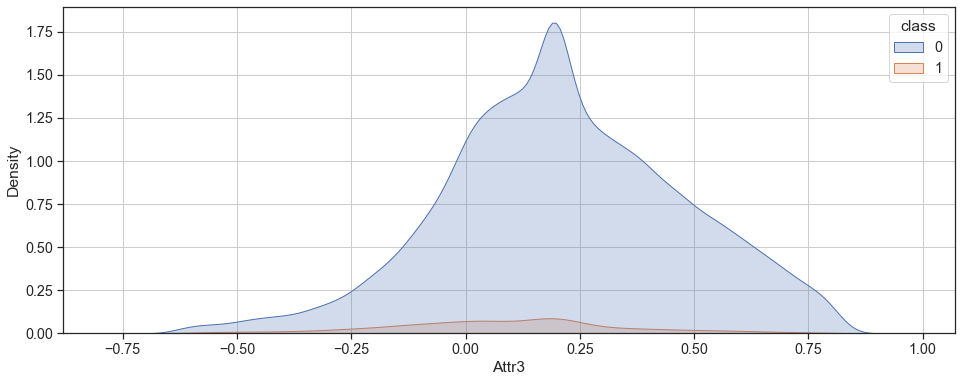

In [26]:
sns.kdeplot(data=df, x="Attr3", hue="class", fill=True)

Podobnie dla zmiennnej `X19`.

<AxesSubplot:xlabel='Attr19', ylabel='Density'>

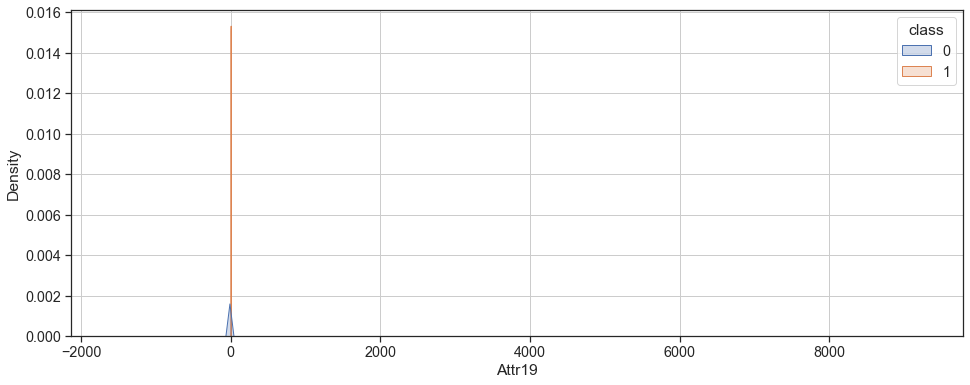

In [27]:
sns.kdeplot(data=df, x="Attr19", hue="class", fill=True)

In [28]:
print(df['Attr19'].quantile(0.02)) 
print(df['Attr19'].quantile(0.98)) 
print(df['Attr19'].quantile(0.5))

-0.3787548
0.3407723999999995
0.035874


In [29]:
df['Attr19'] = np.where((df['Attr19'] > 0.34)|(df['Attr19'] < -0.3787) ,0.0358, df['Attr19'])

<AxesSubplot:xlabel='Attr19', ylabel='Density'>

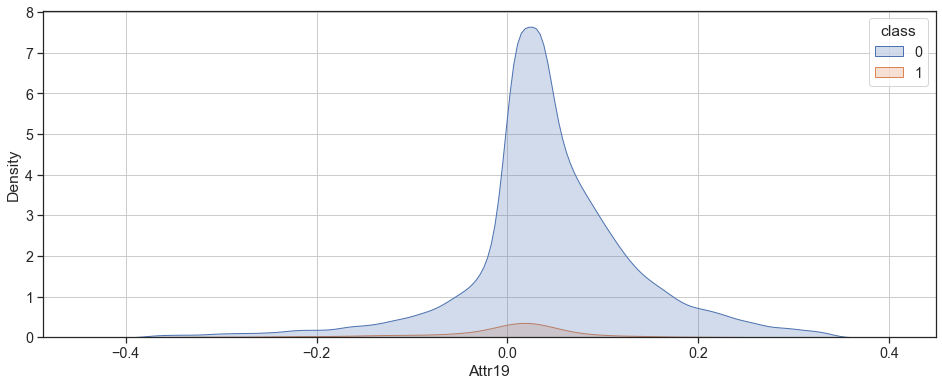

In [30]:
sns.kdeplot(data=df, x="Attr19", hue="class", fill=True)

<AxesSubplot:xlabel='Attr53', ylabel='Density'>

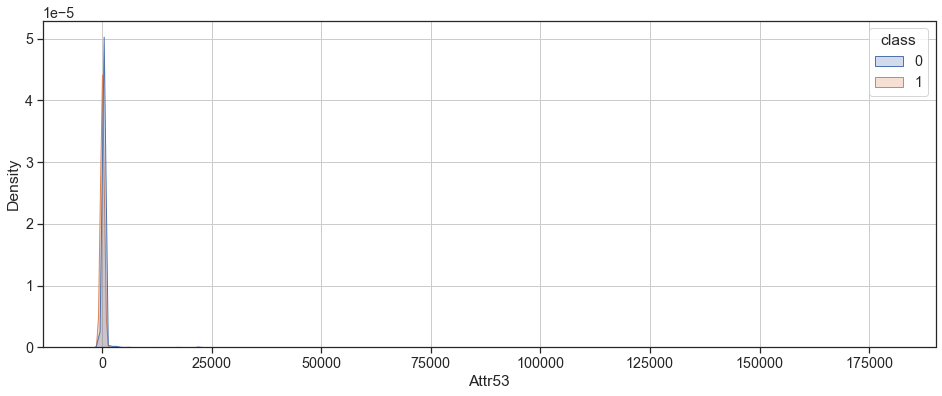

In [31]:
sns.kdeplot(data=df, x="Attr53", hue="class", fill=True)

In [32]:
print(df['Attr53'].quantile(0.02)) 
print(df['Attr53'].quantile(0.98)) 
print(df['Attr53'].quantile(0.5))

-1.6137679999999999
27.99827999999997
1.2053


In [33]:
df['Attr53'] = np.where((df['Attr53'] > 27.998)|(df['Attr53'] < -1.613) ,1.2053, df['Attr53'])

<AxesSubplot:xlabel='Attr53', ylabel='Density'>

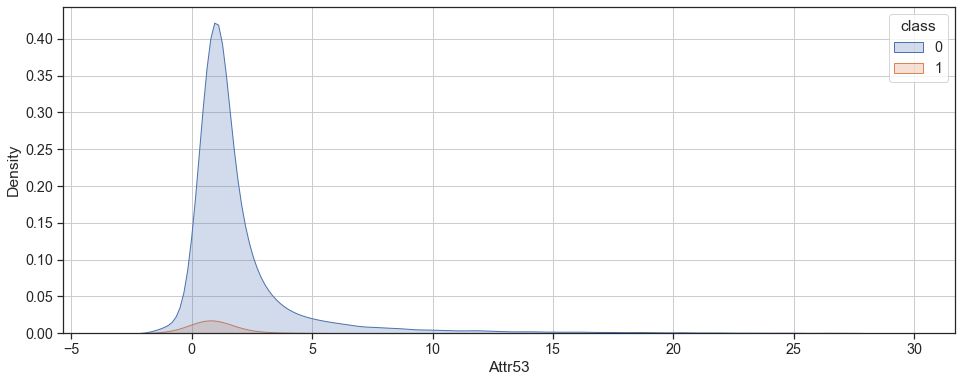

In [34]:
sns.kdeplot(data=df, x="Attr53", hue="class", fill=True)

Tu widać ogromną różnice między dwoma wykresami. Przed usunięciem wartości odstających kolor pomarańczowy niemal pokrywał się z niebieksim. Potwierdza to wniosek, że usunięcie outlierów powoduję zbyt duża utratę znaczących informacji.

## Podsumowanie
* firmy, które zbankrutowały, stanowią niewielką liczbę wszystkich obserwacji, ok. 5%
* możemy usunąć kolumny `X27`, `X21`, `X37` ze względu na dużą liczbę braków danych
* możemy usunąć w większości puste wiersze
* należy zapełnić braki danych w kolumnach, ponieważ każda kolumna pewne braki ma; najlepiej przez medianę, ze względu na wartości odstające
* żadna kolumna nie wydaje się być szczególnie mocno skorelowana z naszymi docelowymi kategoriami
* istnieją grupy bardzo mocno skorelowanych zmiennych; można rozważyć zostawienie tylko jednej kolumny z każdej grupy
* można rozważyć noramlizację zmiennych, ponieważ występuja one w różnych rzędach wielkości 
* wszystkie zmienne mają bardzo dużo wartości odstających oraz koncentrują się w okolicach zera (poza `X27`)
* nie możemy usunąć obserwacji o wielu wartościach odstających, ponieważ byśmy pozbyli się wielu firm, które zbankrutowały